In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit

In [3]:
# training_history_df = pd.read_csv('training_history.csv')
# training_history_df_sorted = training_history_df.sort_values(by='Measured Stimulus')
# training_history_df_sorted

,Trial,Truth,Measured Stimulus,Decision,HP
0,1,True,0.234707,True,1002


mu: 0.23470701607837
sigma: nan


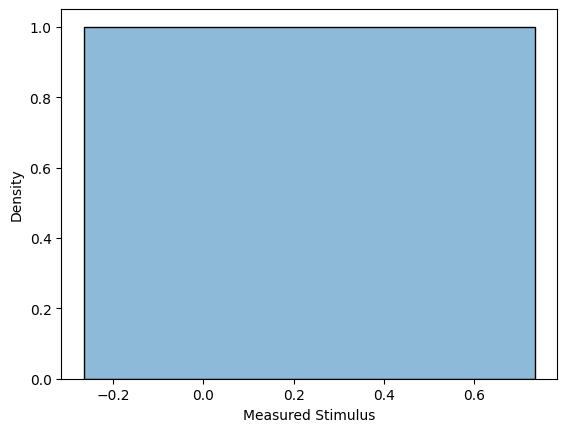

In [4]:
# mu = training_history_df['Measured Stimulus'].mean()
# sigma = training_history_df['Measured Stimulus'].std()

# print(f"mu: {mu}")
# print(f"sigma: {sigma}")

# sns.histplot(training_history_df['Measured Stimulus'], kde=True, stat='density')

# plt.xlabel('Measured Stimulus')
# plt.ylabel('Density')
# plt.show()

In [44]:
def generate_data_csv(min_stimulus, max_stimulus, step, n_trial, s_ref, s_ref_std, experiment_name):
    data = []  
    stimulus_std_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for stimulus_std in stimulus_std_values: 
        stimulus_values = np.arange(min_stimulus, max_stimulus + step, step)  
        for stimulus in stimulus_values: 
            for trial in range(n_trial):  
                row = [
                    1 + (stimulus - min_stimulus) // step,
                    s_ref,
                    s_ref_std,
                    stimulus,
                    stimulus_std
                ]
                data.append(row)

    filename = f"{experiment_name}.csv"
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Trial', 'Stimulus 1 Value', 'Stimulus 1 Std', 'Stimulus 2 Value', 'Stimulus 2 Std'])
        writer.writerows(data)
    
    print(f"Data successfully written to {filename}")


In [61]:
experiment_name = "learning_phase_1"
generate_data_csv(
    min_stimulus = -5,
    max_stimulus = 5,
    step = 0.1,
    n_trial = 100,
    s_ref = 2,
    s_ref_std = 0.1,
    experiment_name=experiment_name
)

Data successfully written to learning_phase_1.csv


In [72]:
learning_phase_1_result = pd.read_csv('experiment_results.csv')

In [73]:
learning_phase_1_result.to_csv('learning_phase_1_result.csv')

In [74]:
learning_phase_10_result = pd.read_csv('learning_phase_1_result.csv')

In [75]:
accuracy_df = (
    learning_phase_1_result
    # .assign(Stimulus_Diff=lambda df: df['Stimulus 2 Value'] - df['Stimulus 1 Value']) 
    .groupby(['Stimulus 2 Std', 'Stimulus 2 Value'])['Comparison Result']
    .apply(lambda x: (x.mean()))
    .reset_index()
    .rename(columns={'Comparison Result': 'Accuracy'})
)
accuracy_df

,Stimulus 2 Std,Stimulus 2 Value,Accuracy
0,0.1,-5.0,1.00
1,0.1,-4.9,1.00
2,0.1,-4.8,1.00
3,0.1,-4.7,1.00
4,0.1,-4.6,1.00
...,...,...,...
904,0.9,4.6,0.02
905,0.9,4.7,0.03
906,0.9,4.8,0.05
907,0.9,4.9,0.02


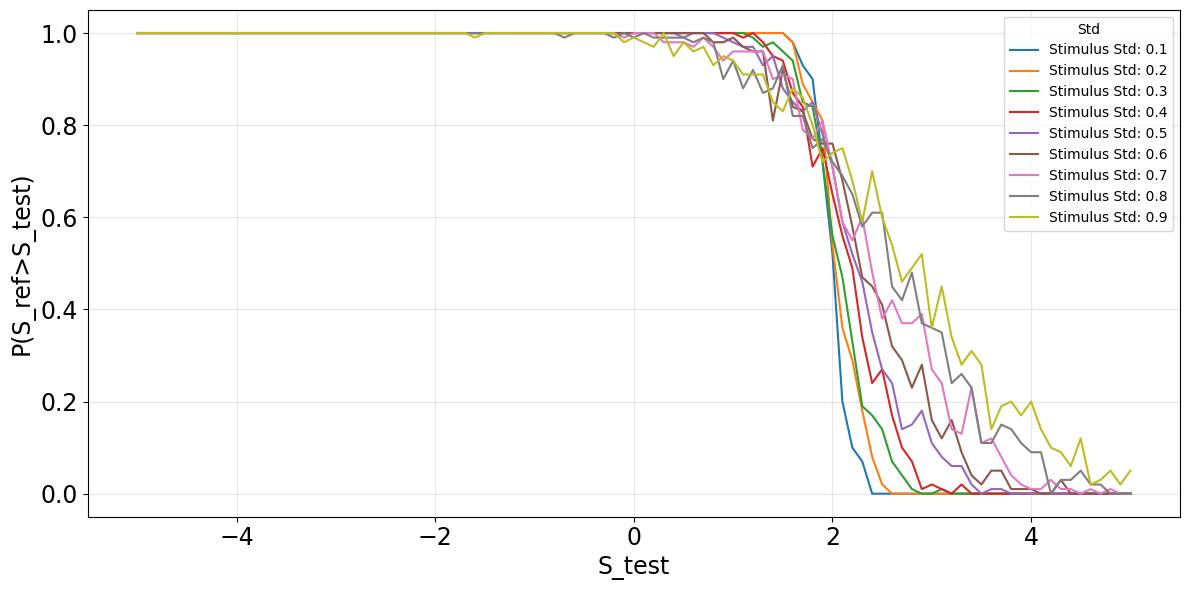

In [76]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    plt.plot(
        grouped_df['Stimulus 2 Value'],
        grouped_df['Accuracy'],
        marker= None,
        label=f"Stimulus Std: {stimulus_std}",
        linestyle='-'
    )

plt.xlabel("S_test", fontsize = 17)
plt.ylabel("P(S_ref>S_test)", fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title="Std")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [17]:
def sigmoid(x, a, b, c, d):
    """
    General sigmoid function:
    y = a / (1 + exp(-c * (x - d))) + b
    """
    return a / (1.0 + np.exp(-c * (x - d))) + b

C:\Users\aslan\AppData\Local\Temp\ipykernel_10772\2302863563.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)


Stimulus Std 0.1: a=-0.9992, b=1.0015, c=11.4073, d=-0.0000
Stimulus Std 0.2: a=-1.0018, b=0.9904, c=6.2772, d=-0.0000
Stimulus Std 0.3: a=-1.0051, b=0.9720, c=3.5392, d=-0.0000
Stimulus Std 0.4: a=-1.0135, b=0.9453, c=1.9723, d=-0.0000
Stimulus Std 0.5: a=-1.0348, b=0.9242, c=1.3086, d=-0.0000
Stimulus Std 0.6: a=-1.0996, b=0.9153, c=0.8217, d=-0.0000
Stimulus Std 0.7: a=-1.4003, b=1.0108, c=0.4249, d=-0.0000
Stimulus Std 0.8: a=-120.2194, b=60.3659, c=0.0035, d=-0.0000
Stimulus Std 0.9: a=-182.7792, b=91.5819, c=0.0018, d=-0.0000


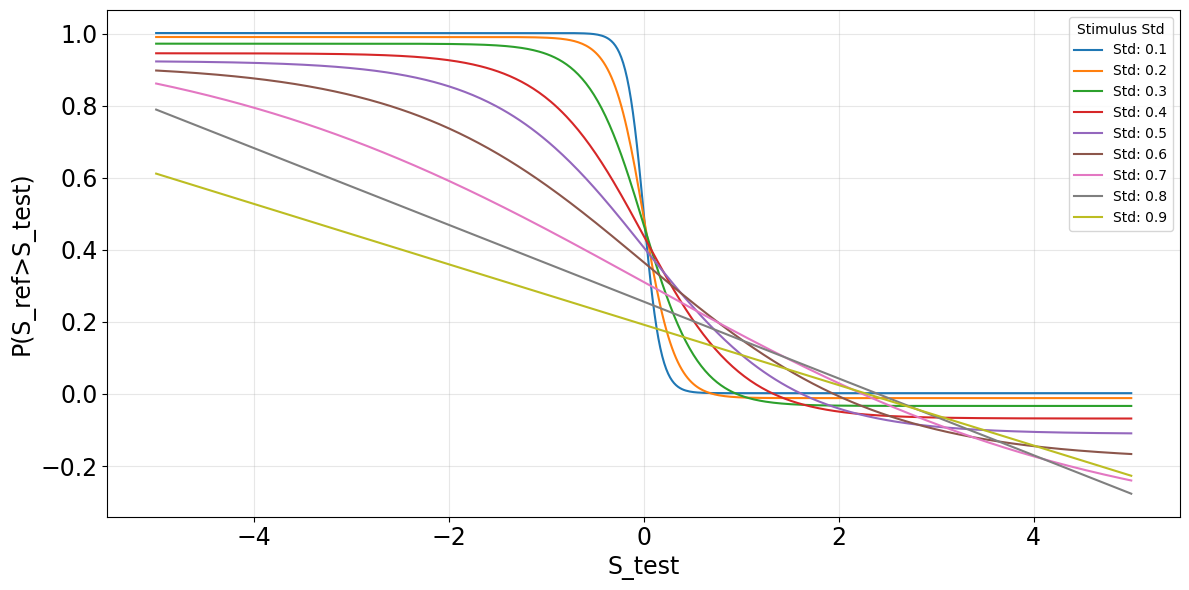

In [18]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
    print(f"Stimulus Std {stimulus_std}: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}, d={popt[3]:.4f}")
    
    x_smooth = np.linspace(min(x_data), max(x_data), 500)
    
    y_smooth = sigmoid(x_smooth, *popt)
    
    plt.plot(
        x_smooth, y_smooth,
        linestyle='-',  
        label=f"Std: {stimulus_std}"
    )

plt.xlabel("S_test", fontsize=17)
plt.ylabel("P(S_ref>S_test)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Stimulus Std", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [37]:
learning_phase_2_result = pd.read_csv('experiment_results.csv')

In [38]:
learning_phase_2_result.to_csv('learning_phase_2_result.csv')

In [39]:
learning_phase_2_result = pd.read_csv('learning_phase_2_result.csv')

In [40]:
accuracy_df = (
    learning_phase_2_result
    # .assign(Stimulus_Diff=lambda df: df['Stimulus 2 Value'] - df['Stimulus 1 Value']) 
    .groupby(['Stimulus 2 Std', 'Stimulus 2 Value'])['Comparison Result']
    .apply(lambda x: (x.mean()))
    .reset_index()
    .rename(columns={'Comparison Result': 'Accuracy'})
)
accuracy_df

,Stimulus 2 Std,Stimulus 2 Value,Accuracy
0,0.1,-5.0,1.0
1,0.1,-4.9,1.0
2,0.1,-4.8,1.0
3,0.1,-4.7,1.0
4,0.1,-4.6,1.0
...,...,...,...
904,0.9,4.6,0.0
905,0.9,4.7,0.0
906,0.9,4.8,0.0
907,0.9,4.9,0.0


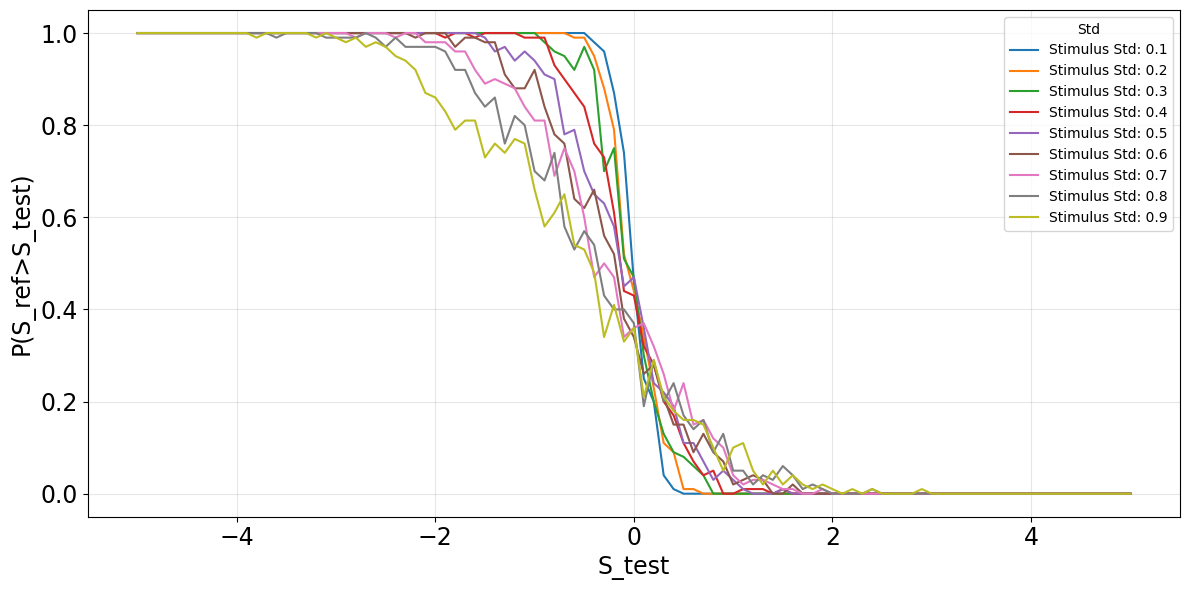

In [41]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    plt.plot(
        grouped_df['Stimulus 2 Value'],
        grouped_df['Accuracy'],
        marker= None,
        label=f"Stimulus Std: {stimulus_std}",
        linestyle='-'
    )

plt.xlabel("S_test", fontsize = 17)
plt.ylabel("P(S_ref>S_test)", fontsize = 17)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title="Std")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


C:\Users\aslan\AppData\Local\Temp\ipykernel_10772\2302863563.py:9: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)


Stimulus Std 0.1: a=-1.0008, b=1.0005, c=9.5006, d=-0.0000
Stimulus Std 0.2: a=-1.0026, b=0.9998, c=6.3110, d=-0.0000
Stimulus Std 0.3: a=-0.9996, b=0.9952, c=5.1453, d=-0.0000
Stimulus Std 0.4: a=-1.0025, b=0.9937, c=3.6534, d=-0.0000
Stimulus Std 0.5: a=-1.0037, b=0.9875, c=2.8204, d=-0.0000
Stimulus Std 0.6: a=-1.0052, b=0.9794, c=2.2868, d=-0.0000
Stimulus Std 0.7: a=-1.0096, b=0.9774, c=1.8570, d=-0.0000
Stimulus Std 0.8: a=-1.0102, b=0.9647, c=1.5725, d=-0.0000
Stimulus Std 0.9: a=-1.0117, b=0.9502, c=1.3190, d=-0.0000


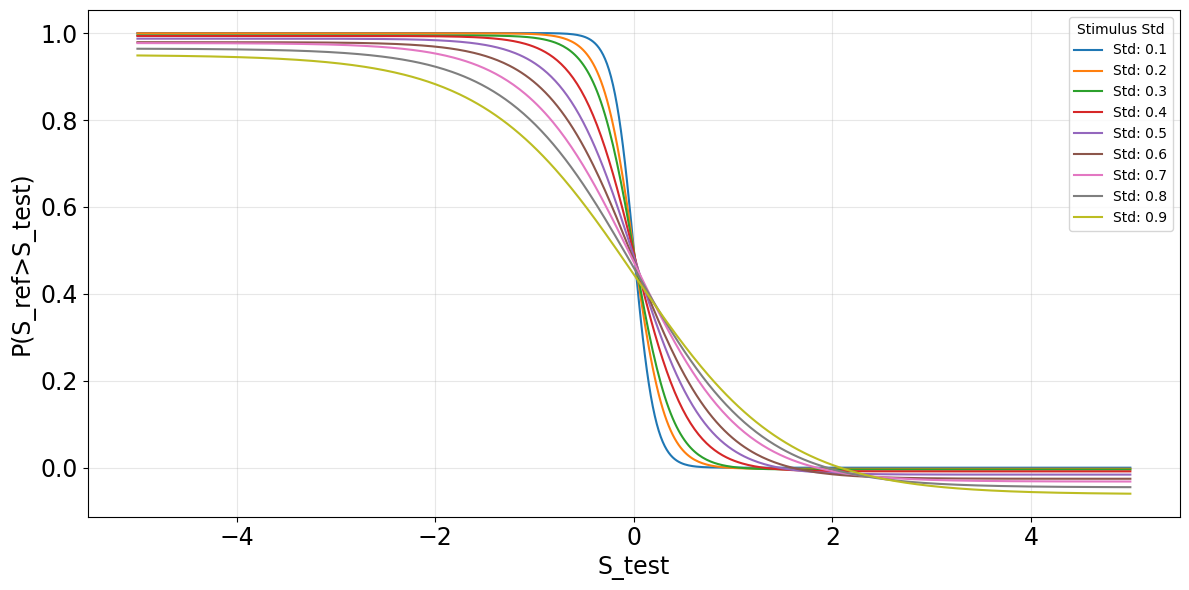

In [42]:
plt.figure(figsize=(12, 6))

for stimulus_std, grouped_df in accuracy_df.groupby('Stimulus 2 Std'):
    x_data = grouped_df['Stimulus 2 Value'].values
    y_data = grouped_df['Accuracy'].values

    initial_guess = [1.0, 0.0, 10.0, np.median(x_data)]
    
    popt, _ = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
    
    print(f"Stimulus Std {stimulus_std}: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}, d={popt[3]:.4f}")
    
    x_smooth = np.linspace(min(x_data), max(x_data), 500)
    
    y_smooth = sigmoid(x_smooth, *popt)
    
    plt.plot(
        x_smooth, y_smooth,
        linestyle='-',  
        label=f"Std: {stimulus_std}"
    )

plt.xlabel("S_test", fontsize=17)
plt.ylabel("P(S_ref>S_test)", fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(title="Stimulus Std", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()
